In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

# Load dataset
station_data = pd.read_csv('/kaggle/input/electric-vehicle-charging-dataset/station_data_dataverse.csv')

In [2]:
# Display columns
print(station_data.columns)


Index(['sessionId', 'kwhTotal', 'dollars', 'created', 'ended', 'startTime',
       'endTime', 'chargeTimeHrs', 'weekday', 'platform', 'distance', 'userId',
       'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon',
       'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip'],
      dtype='object')


#   Scenario 1: Price Surge 

In [3]:
# Define demand function
def demand_function(price):
    """Demand function for EV owners based on price."""
    return max(100 - 5 * price, 0)


In [4]:
import pandas as pd
import numpy as np

def demand_function(price):
    """Define a demand function based on price."""
    base_demand = 100  # Base demand at zero price
    price_sensitivity = 10  # How sensitive demand is to price changes
    return max(0, base_demand - (price * price_sensitivity))

def price_surge_simulation(station_data):
    """Simulate a price surge at selected stations using a Stackelberg model."""
    surge_price = 2.0  # Increase price significantly for testing
    affected_stations = station_data.sample(frac=0.1)  # Randomly select 10% of stations

    # Create a copy of the original station data to track user behavior
    updated_station_data = station_data.copy()

    # Apply price surge to affected stations
    for index, station in affected_stations.iterrows():
        updated_station_data.at[index, 'dollars'] *= surge_price  # Apply price surge

    # Calculate new demand based on the updated prices
    updated_station_data['new_demand'] = updated_station_data['dollars'].apply(demand_function)

    # Simulate user switching behavior based on price thresholds
    for index, station in affected_stations.iterrows():
        # Simulate behavior for users at this station
        current_demand = updated_station_data.at[index, 'new_demand']
        alternative_stations = updated_station_data[updated_station_data['stationId'] != station['stationId']]

        # Assume a threshold where users will switch if the price is too high
        switch_threshold = 1.5 * station['dollars']  # 50% higher than the original price
        switched_users = alternative_stations[alternative_stations['dollars'] < switch_threshold]

        # Adjust demand for the station based on how many switched
        updated_station_data.at[index, 'new_demand'] -= len(switched_users)

    return updated_station_data

# Example usage:
station_data = pd.DataFrame({
    'stationId': range(1, 101),
    'dollars': np.random.uniform(0.5, 1.5, 100)  # Random prices between $0.5 and $1.5
})

# Run the price surge simulation
updated_station_data = price_surge_simulation(station_data)

# Display the results
print(updated_station_data[['stationId', 'dollars', 'new_demand']])


    stationId   dollars  new_demand
0           1  0.637069   93.629311
1           2  0.734548   92.654524
2           3  1.556080   24.439198
3           4  1.150960   88.490397
4           5  1.459767   85.402328
..        ...       ...         ...
95         96  0.821147   91.788531
96         97  1.239917   87.600832
97         98  1.206101   87.938989
98         99  1.001645   89.983551
99        100  0.500869   94.991309

[100 rows x 3 columns]


indicates how demand changes based on the price adjustments.

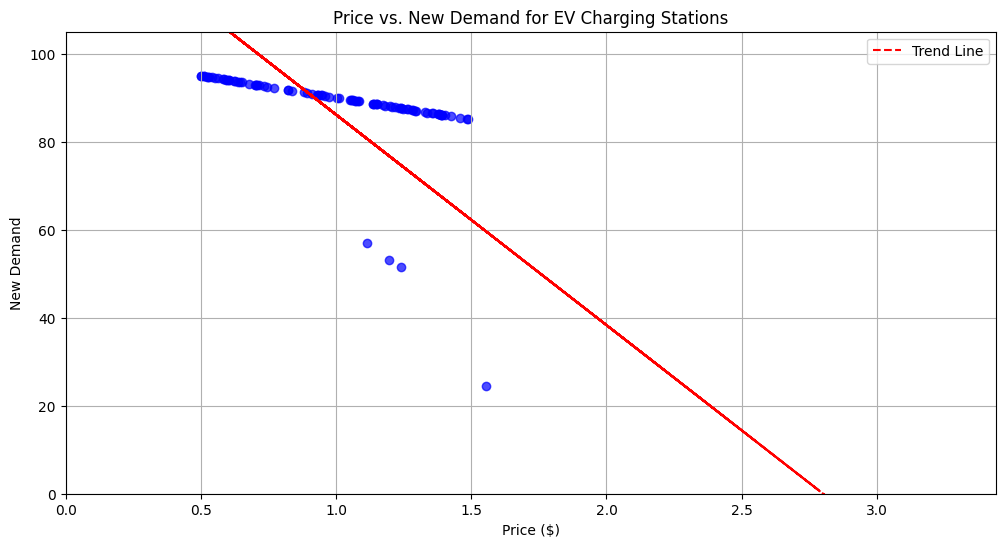

In [5]:
import matplotlib.pyplot as plt

def plot_price_vs_demand(updated_station_data):
    """Plot the relationship between price and new demand."""
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of prices vs new demand
    plt.scatter(updated_station_data['dollars'], updated_station_data['new_demand'], color='blue', alpha=0.7)

    # Adding a trend line
    z = np.polyfit(updated_station_data['dollars'], updated_station_data['new_demand'], 1)
    p = np.poly1d(z)
    plt.plot(updated_station_data['dollars'], p(updated_station_data['dollars']), color='red', linestyle='--', label='Trend Line')

    # Titles and labels
    plt.title('Price vs. New Demand for EV Charging Stations')
    plt.xlabel('Price ($)')
    plt.ylabel('New Demand')
    plt.xlim(0, updated_station_data['dollars'].max() + 0.5)
    plt.ylim(0, updated_station_data['new_demand'].max() + 10)
    plt.grid()
    plt.legend()
    plt.show()

# Call the plotting function
plot_price_vs_demand(updated_station_data)


#  Scenario 2: Overload Simulation 

   sessionId   kwhTotal   dollars  new_demand
0          1   4.416799  1.063625         NaN
1          2  15.128048  1.505321   24.733963
2          3   8.944090  1.316904         NaN
3          4   3.760013  1.292728         NaN
4          5  20.977256  1.278453   36.077342


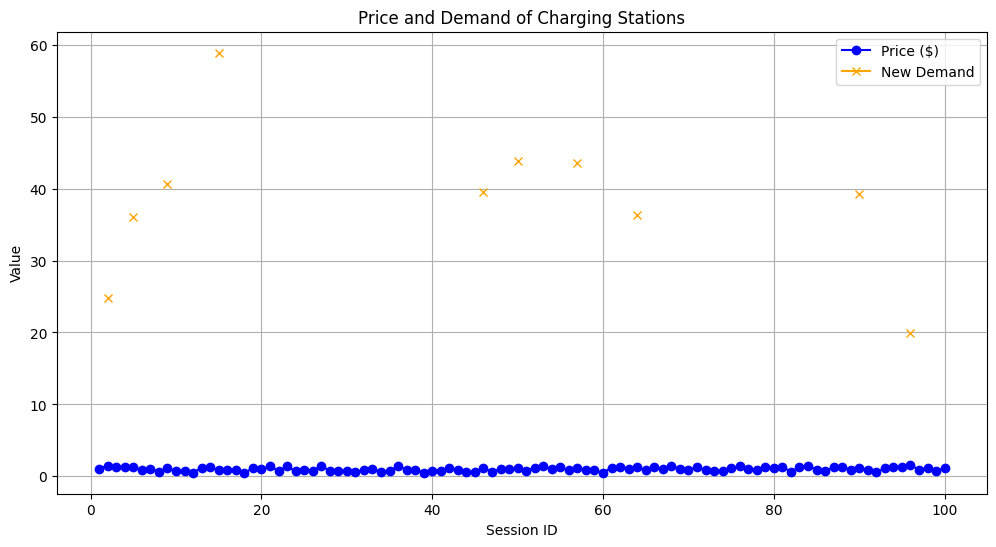

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function for demand response based on price
def demand_response(price):
    """Estimate demand based on price."""
    # Assume a linear demand function: as price increases, demand decreases
    return max(100 - (price * 50), 0)  # Adjust the parameters based on your needs

# Overload simulation with Stackelberg Pricing Model
def overload_simulation_with_pricing(station_data):
    """
    Simulate high demand at a few stations and adjust prices accordingly.
    
    Parameters:
    station_data (DataFrame): The DataFrame containing charging station data.
    
    Returns:
    DataFrame: Updated station data with new prices and demand.
    """
    overloaded_stations = station_data.sample(frac=0.1)  # Randomly select 10% of stations
    overload_increase = 15  # Increase kWh total by 15 for overloaded stations
    
    # Increase the kWh total for overloaded stations
    for index, station in overloaded_stations.iterrows():
        station_data.at[index, 'kwhTotal'] += overload_increase  # Simulate increased demand

    # Update prices and calculate new demand based on overload
    for index, station in overloaded_stations.iterrows():
        # Increase price based on overload situation
        new_price = station_data.at[index, 'dollars'] * (1 + (overload_increase / 100))  # Increase by a certain percentage
        station_data.at[index, 'dollars'] = new_price
        # Update demand based on new price
        station_data.at[index, 'new_demand'] = demand_response(new_price)

    return station_data

# Sample station data for testing
# Create a sample DataFrame with random data
data = {
    'sessionId': range(1, 101),
    'kwhTotal': np.random.uniform(0, 10, 100),  # Random kWh totals
    'dollars': np.random.uniform(0.5, 1.5, 100)  # Random prices
}
station_data = pd.DataFrame(data)

# Run the overload simulation with pricing
updated_station_data = overload_simulation_with_pricing(station_data)

# Display updated data for verification
print(updated_station_data.head())

# Function to plot the prices and demands
def plot_price_vs_demand(station_data):
    """Plot the prices and demands of charging stations."""
    plt.figure(figsize=(12, 6))
    plt.plot(station_data['sessionId'], station_data['dollars'], label='Price ($)', color='blue', marker='o')
    plt.plot(station_data['sessionId'], station_data['new_demand'], label='New Demand', color='orange', marker='x')
    plt.title('Price and Demand of Charging Stations')
    plt.xlabel('Session ID')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plotting function to visualize the results
plot_price_vs_demand(updated_station_data)


Session 20: Price 1.60, Demand 85.68
Session 22: Price 1.49, Demand 86.33
Session 42: Price 0.71, Demand 91.96
Session 39: Price 1.59, Demand 85.73
Session 27: Price 0.61, Demand 92.86
Session 96: Price 1.71, Demand 85.06
Session 0: Price 1.70, Demand 85.12
Session 70: Price 1.13, Demand 88.64
Session 10: Price 1.25, Demand 87.86
Session 87: Price 0.69, Demand 92.09
   sessionId   kwhTotal   dollars  new_demand
0          1  22.230578  1.696673   85.119716
1          2   2.423553  1.167414    0.000000
2          3   4.150730  1.026680    0.000000
3          4   0.535832  0.807718    0.000000
4          5   3.835222  1.250305    0.000000


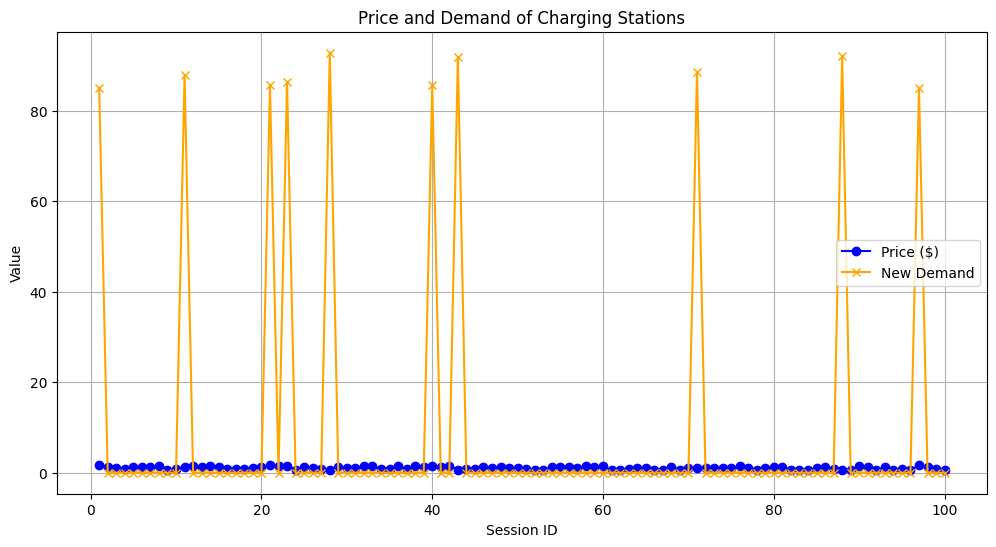

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def demand_response(price):
    """Estimate demand based on price using a smoother demand curve with minimum demand."""
    # Ensure the price is a valid number and return demand based on the price
    if price > 0:
        # Using a logarithmic decrease, with a minimum demand threshold of 5
        return max(5, 100 - np.log(price + 1) * 15)
    else:
        return 0  # If the price is invalid or zero, return zero demand


# Overload simulation with Stackelberg Pricing Model and Price Cap
def overload_simulation_with_pricing(station_data, price_cap=3.0):
    """
    Simulate high demand at a few stations and adjust prices accordingly.
    
    Parameters:
    station_data (DataFrame): The DataFrame containing charging station data.
    price_cap (float): The maximum allowed price to prevent unrealistic spikes.
    
    Returns:
    DataFrame: Updated station data with new prices and demand.
    """
    overloaded_stations = station_data.sample(frac=0.1)  # Randomly select 10% of stations
    overload_increase = 15  # Increase kWh total by 15 for overloaded stations
    
    # Increase the kWh total for overloaded stations
    for index, station in overloaded_stations.iterrows():
        station_data.at[index, 'kwhTotal'] += overload_increase  # Simulate increased demand

    # Update prices and calculate new demand based on overload
    for index, station in overloaded_stations.iterrows():
        if station_data.at[index, 'dollars'] > 0:
            # Increase price based on overload situation
            new_price = station_data.at[index, 'dollars'] * (1 + (overload_increase / 100))
            # Cap the price to avoid unrealistic spikes
            new_price = min(new_price, price_cap)
            station_data.at[index, 'dollars'] = new_price
            # Update demand based on the new price using the adjusted demand response
            station_data.at[index, 'new_demand'] = demand_response(new_price)
            print(f"Session {index}: Price {new_price:.2f}, Demand {station_data.at[index, 'new_demand']:.2f}")
        else:
            station_data.at[index, 'new_demand'] = 0  # Set demand to 0 if price is invalid

    return station_data

# Sample station data for testing
# Create a sample DataFrame with random data
data = {
    'sessionId': range(1, 101),
    'kwhTotal': np.random.uniform(0, 10, 100),  # Random kWh totals
    'dollars': np.random.uniform(0.5, 1.5, 100)  # Random prices
}
station_data = pd.DataFrame(data)

# Initialize the new_demand column with zeros to avoid NaN values
station_data['new_demand'] = 0.0

# Run the overload simulation with pricing
updated_station_data = overload_simulation_with_pricing(station_data)

# Display updated data for verification
print(updated_station_data.head())

# Function to plot the prices and demands
def plot_price_vs_demand(station_data):
    """Plot the prices and demands of charging stations."""
    plt.figure(figsize=(12, 6))
    plt.plot(station_data['sessionId'], station_data['dollars'], label='Price ($)', color='blue', marker='o')
    plt.plot(station_data['sessionId'], station_data['new_demand'], label='New Demand', color='orange', marker='x')
    plt.title('Price and Demand of Charging Stations')
    plt.xlabel('Session ID')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plotting function to visualize the results
plot_price_vs_demand(updated_station_data)


# Scenario 3: Dynamic Pricing Adjustment Based on Peak and Off-Peak Hours 

   sessionId  kwhTotal  startTime  dollars  new_demand
0          1  8.709853         14     0.25        87.5
1          2  6.550920          1     0.25        87.5
2          3  0.178151         15     0.25        87.5
3          4  0.562917         16     0.25        87.5
4          5  5.568067         10     0.25        87.5


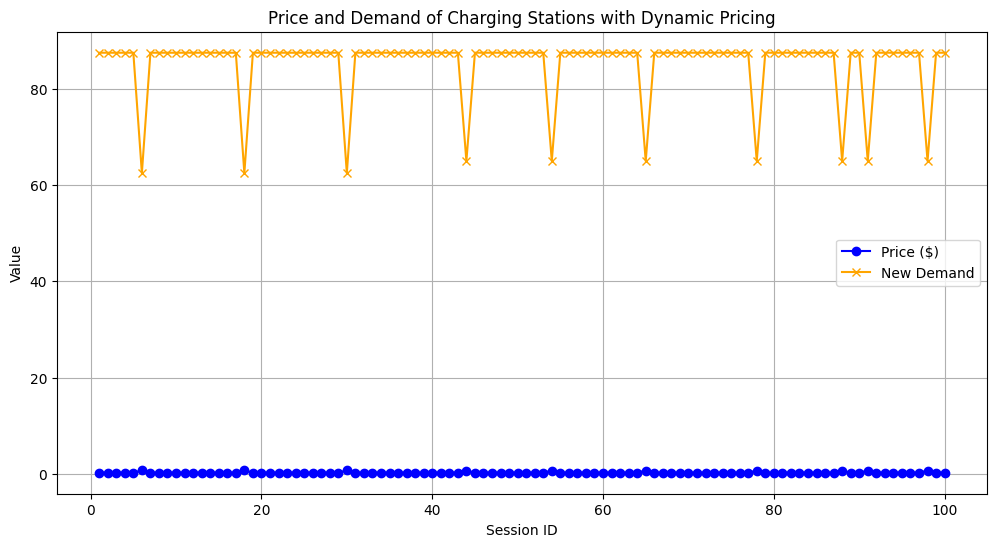

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function for demand response based on price
def demand_response(price):
    """Estimate demand based on price."""
    return max(100 - (price * 50), 0)  # Example: linear demand function

# Dynamic Pricing Simulation with Game Theory Approach
def dynamic_pricing_simulation(station_data):
    """
    Adjust prices based on peak and off-peak hours and simulate game theory interactions.
    
    Parameters:
    station_data (DataFrame): The DataFrame containing charging station data.
    
    Returns:
    DataFrame: Updated station data with new prices and demand.
    """
    peak_hours = [8, 9, 17, 18]  # Define peak hours
    off_peak_price = 0.25
    peak_price = 0.75  # Higher peak price

    # Adjust prices based on hours and simulate game theory
    for index, row in station_data.iterrows():
        hour = row['startTime']  # Assuming startTime is in 24-hour format
        if hour in peak_hours:
            station_data.at[index, 'dollars'] = peak_price
        else:
            station_data.at[index, 'dollars'] = off_peak_price
        
        # Game theory interaction: Adjust prices based on competitor pricing
        competitor_price = station_data['dollars'].mean()  # Average competitor price
        if station_data.at[index, 'dollars'] > competitor_price:
            # Reduce price slightly to attract more customers
            station_data.at[index, 'dollars'] -= 0.05
    
    # Calculate new demand based on the updated prices
    station_data['new_demand'] = station_data['dollars'].apply(demand_response)
    return station_data

# Sample station data for testing
# Create a sample DataFrame with random data including startTime
data = {
    'sessionId': range(1, 101),
    'kwhTotal': np.random.uniform(0, 10, 100),  # Random kWh totals
    'startTime': np.random.randint(0, 24, 100),  # Random start time in hours
    'dollars': np.random.uniform(0.5, 1.5, 100)  # Random initial prices
}
station_data = pd.DataFrame(data)

# Run the dynamic pricing simulation
updated_station_data = dynamic_pricing_simulation(station_data)

# Display updated data for verification
print(updated_station_data.head())

# Function to plot the prices and demands
def plot_price_vs_demand(station_data):
    """Plot the prices and demands of charging stations."""
    plt.figure(figsize=(12, 6))
    plt.plot(station_data['sessionId'], station_data['dollars'], label='Price ($)', color='blue', marker='o')
    plt.plot(station_data['sessionId'], station_data['new_demand'], label='New Demand', color='orange', marker='x')
    plt.title('Price and Demand of Charging Stations with Dynamic Pricing')
    plt.xlabel('Session ID')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plotting function to visualize the results
plot_price_vs_demand(updated_station_data)


# Scenario 4: Malicious User Behavior – Resource Hoarding

# **AES Encryption Code**

In [2]:
!pip install PyCryptodome


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_30/4120205767.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  station_data.loc[station_data['is_malicious'], 'price_per_hour'] = base_price * premium_multiplier


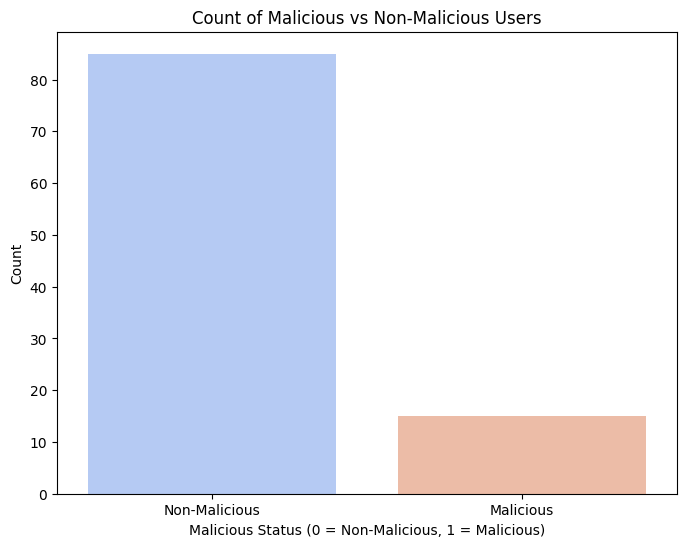

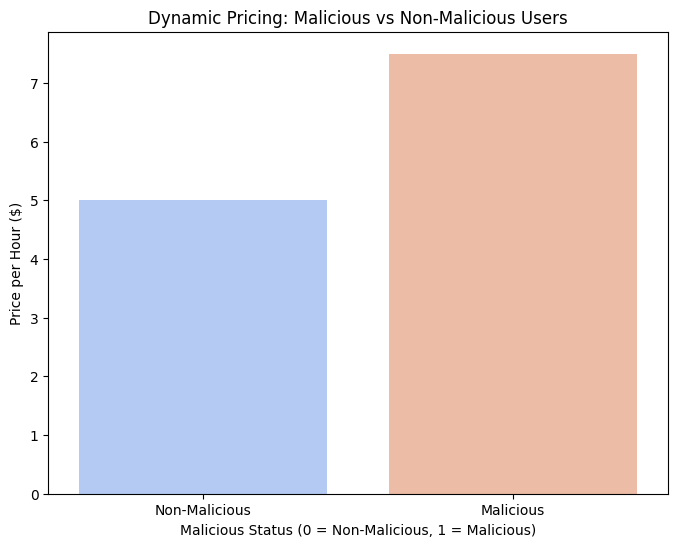

In [10]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import base64
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions for AES encryption and decryption
def pad(data):
    """ Pad data to be multiple of 16 bytes for AES encryption """
    return data + b' ' * (16 - len(data) % 16)

def encrypt(data, key):
    """ Encrypts data using AES encryption """
    cipher = AES.new(key, AES.MODE_ECB)
    return base64.b64encode(cipher.encrypt(pad(data)))

def decrypt(encrypted_data, key):
    """ Decrypts data using AES decryption """
    cipher = AES.new(key, AES.MODE_ECB)
    return cipher.decrypt(base64.b64decode(encrypted_data)).strip()

# Generate a random AES key for encryption
key = get_random_bytes(16)

# Sample Data: Simulating EV charging behavior dataset for malicious detection
np.random.seed(42)
data = {
    'userId': np.random.randint(1, 50, 100),
    'sessionId': range(1, 101),
    'reservationCount': np.random.randint(1, 5, 100),
    'actualUsage': np.random.choice([0, 1], size=100, p=[0.3, 0.7]),
    'cancellations': np.random.randint(0, 5, 100),
    'chargeTimeHrs': np.random.uniform(0, 10, 100),
}
station_data = pd.DataFrame(data)

# Simulate malicious behavior by injecting anomalies
malicious_users = np.random.choice(station_data.index, size=10, replace=False)
station_data.loc[malicious_users, 'reservationCount'] = np.random.randint(5, 10, size=10)
station_data.loc[malicious_users, 'actualUsage'] = 0
station_data.loc[malicious_users, 'cancellations'] = np.random.randint(3, 5, size=10)

# Encrypt sensitive fields
station_data['encrypted_reservationCount'] = station_data['reservationCount'].apply(lambda x: encrypt(str(x).encode(), key))
station_data['encrypted_actualUsage'] = station_data['actualUsage'].apply(lambda x: encrypt(str(x).encode(), key))
station_data['encrypted_cancellations'] = station_data['cancellations'].apply(lambda x: encrypt(str(x).encode(), key))
station_data['encrypted_chargeTimeHrs'] = station_data['chargeTimeHrs'].apply(lambda x: encrypt(str(x).encode(), key))

# Decrypt data in a secure environment
station_data['decrypted_reservationCount'] = station_data['encrypted_reservationCount'].apply(lambda x: int(decrypt(x, key).decode()))
station_data['decrypted_actualUsage'] = station_data['encrypted_actualUsage'].apply(lambda x: int(decrypt(x, key).decode()))
station_data['decrypted_cancellations'] = station_data['encrypted_cancellations'].apply(lambda x: int(decrypt(x, key).decode()))
station_data['decrypted_chargeTimeHrs'] = station_data['encrypted_chargeTimeHrs'].apply(lambda x: float(decrypt(x, key).decode()))

# Apply Isolation Forest on decrypted data
X = station_data[['decrypted_reservationCount', 'decrypted_actualUsage', 'decrypted_cancellations', 'decrypted_chargeTimeHrs']]
iso_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
station_data['anomaly'] = iso_forest.fit_predict(X)
station_data['is_malicious'] = station_data['anomaly'] == -1

# Stackelberg Model: Dynamic Pricing based on detected anomalies
base_price = 5  # Base price per hour for charging
premium_multiplier = 1.5  # Premium multiplier for malicious users
station_data['price_per_hour'] = base_price

# Update prices based on malicious behavior
station_data.loc[station_data['is_malicious'], 'price_per_hour'] = base_price * premium_multiplier

# Visualization 1: Bar Graph of Malicious vs Non-Malicious Users
malicious_counts = station_data['is_malicious'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=malicious_counts.index, y=malicious_counts.values, palette="coolwarm")
plt.title('Count of Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
plt.show()

# Visualization 2: Bar Graph of Dynamic Pricing for Malicious and Non-Malicious Users
price_data = station_data.groupby('is_malicious')['price_per_hour'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=price_data['is_malicious'], y=price_data['price_per_hour'], palette="coolwarm")
plt.title('Dynamic Pricing: Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Price per Hour ($)')
plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_30/1144280297.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  station_data.loc[station_data['is_malicious'], 'price_per_hour'] = base_price * premium_multiplier


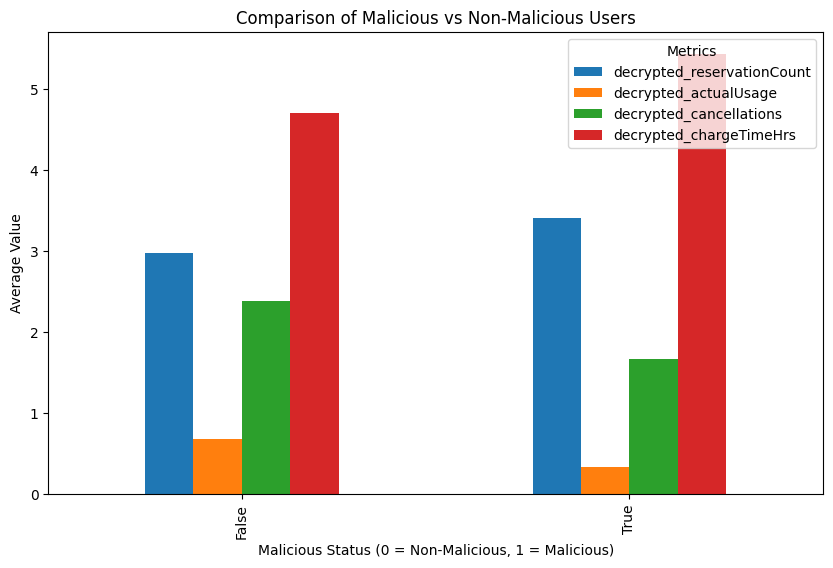

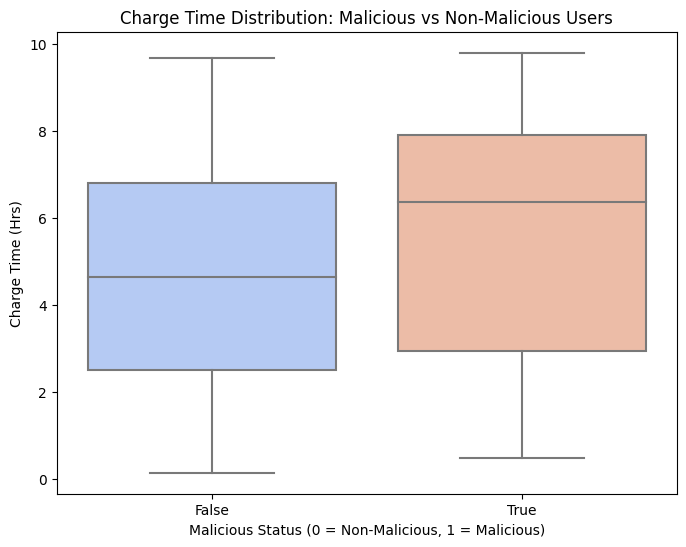

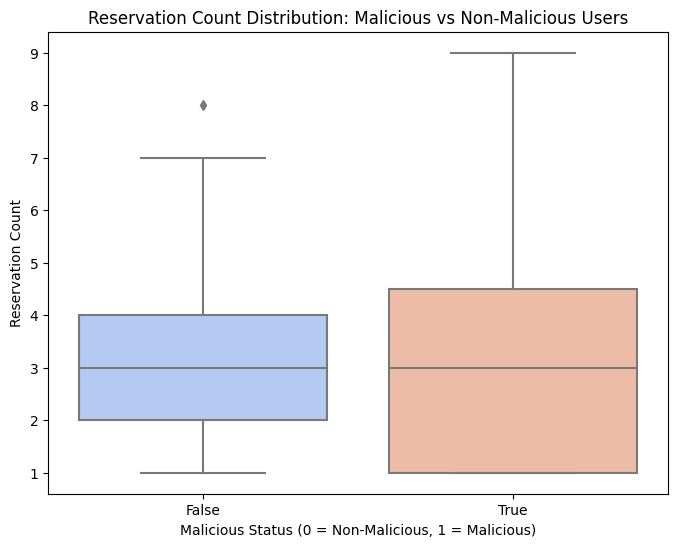

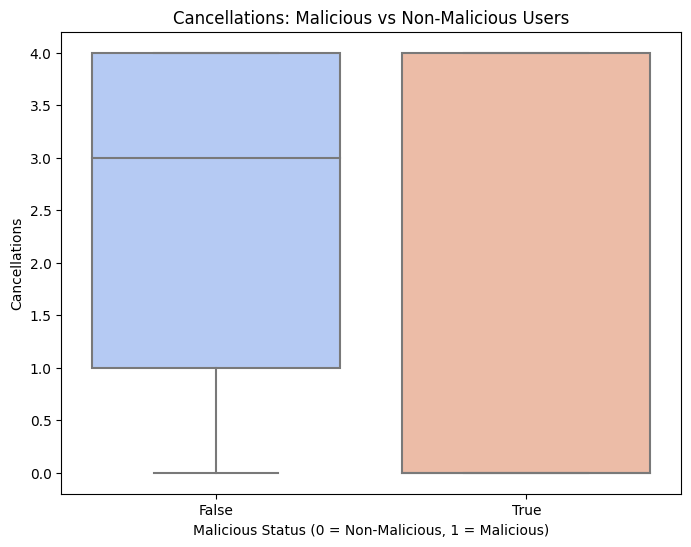

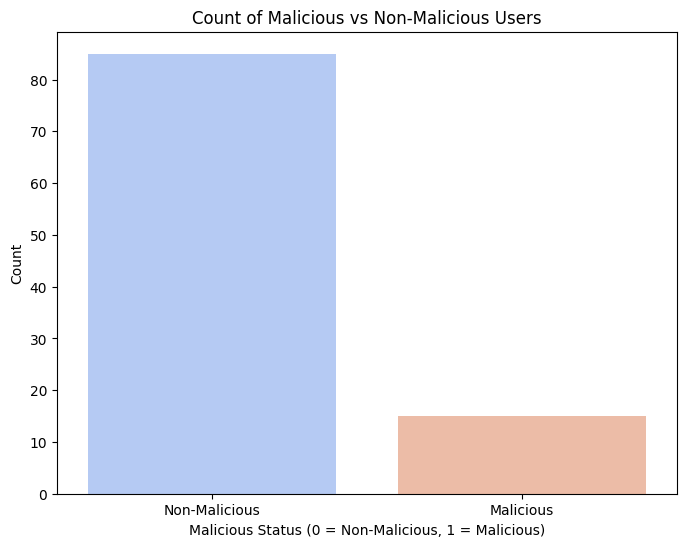

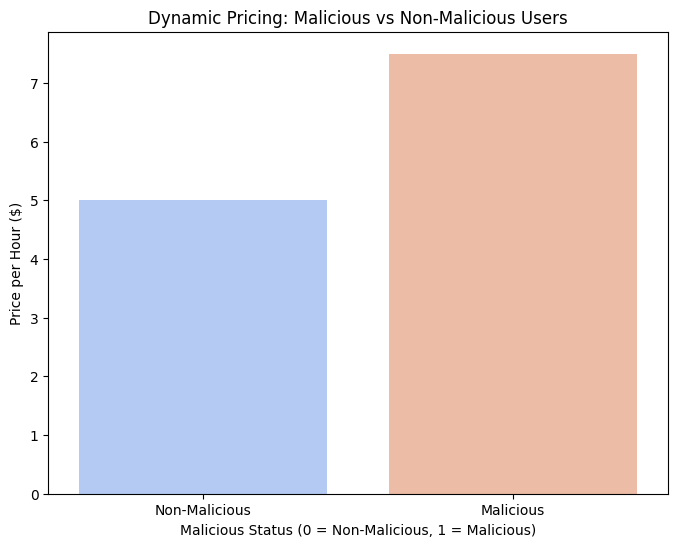

In [31]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import base64
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions for AES encryption and decryption
def pad(data):
    """ Pad data to be multiple of 16 bytes for AES encryption """
    return data + b' ' * (16 - len(data) % 16)

def encrypt(data, key):
    """ Encrypts data using AES encryption """
    cipher = AES.new(key, AES.MODE_ECB)
    return base64.b64encode(cipher.encrypt(pad(data)))

def decrypt(encrypted_data, key):
    """ Decrypts data using AES decryption """
    cipher = AES.new(key, AES.MODE_ECB)
    return cipher.decrypt(base64.b64decode(encrypted_data)).strip()

# Generate a random AES key for encryption
key = get_random_bytes(16)

# Sample Data: Simulating EV charging behavior dataset for malicious detection
np.random.seed(42)
data = {
    'userId': np.random.randint(1, 50, 100),
    'sessionId': range(1, 101),
    'reservationCount': np.random.randint(1, 5, 100),
    'actualUsage': np.random.choice([0, 1], size=100, p=[0.3, 0.7]),
    'cancellations': np.random.randint(0, 5, 100),
    'chargeTimeHrs': np.random.uniform(0, 10, 100),
}
station_data = pd.DataFrame(data)

# Simulate malicious behavior by injecting anomalies
malicious_users = np.random.choice(station_data.index, size=10, replace=False)
station_data.loc[malicious_users, 'reservationCount'] = np.random.randint(5, 10, size=10)
station_data.loc[malicious_users, 'actualUsage'] = 0
station_data.loc[malicious_users, 'cancellations'] = np.random.randint(3, 5, size=10)

# Encrypt sensitive fields
station_data['encrypted_reservationCount'] = station_data['reservationCount'].apply(lambda x: encrypt(str(x).encode(), key))
station_data['encrypted_actualUsage'] = station_data['actualUsage'].apply(lambda x: encrypt(str(x).encode(), key))
station_data['encrypted_cancellations'] = station_data['cancellations'].apply(lambda x: encrypt(str(x).encode(), key))
station_data['encrypted_chargeTimeHrs'] = station_data['chargeTimeHrs'].apply(lambda x: encrypt(str(x).encode(), key))

# Decrypt data in a secure environment
station_data['decrypted_reservationCount'] = station_data['encrypted_reservationCount'].apply(lambda x: int(decrypt(x, key).decode()))
station_data['decrypted_actualUsage'] = station_data['encrypted_actualUsage'].apply(lambda x: int(decrypt(x, key).decode()))
station_data['decrypted_cancellations'] = station_data['encrypted_cancellations'].apply(lambda x: int(decrypt(x, key).decode()))
station_data['decrypted_chargeTimeHrs'] = station_data['encrypted_chargeTimeHrs'].apply(lambda x: float(decrypt(x, key).decode()))

# Apply Isolation Forest on decrypted data
X = station_data[['decrypted_reservationCount', 'decrypted_actualUsage', 'decrypted_cancellations', 'decrypted_chargeTimeHrs']]
iso_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
station_data['anomaly'] = iso_forest.fit_predict(X)
station_data['is_malicious'] = station_data['anomaly'] == -1

# Stackelberg Model: Dynamic Pricing based on detected anomalies
base_price = 5  # Base price per hour for charging
premium_multiplier = 1.5  # Premium multiplier for malicious users
station_data['price_per_hour'] = base_price

# Update prices based on malicious behavior
station_data.loc[station_data['is_malicious'], 'price_per_hour'] = base_price * premium_multiplier

# Visualization 1: Comparison of Malicious vs Non-Malicious Users (Key Metrics)
metrics = ['decrypted_reservationCount', 'decrypted_actualUsage', 'decrypted_cancellations', 'decrypted_chargeTimeHrs']
station_data.groupby('is_malicious')[metrics].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Average Value')
plt.legend(title='Metrics')
plt.show()

# Visualization 2: Charge Time Distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_malicious', y='decrypted_chargeTimeHrs', data=station_data, palette="coolwarm")
plt.title('Charge Time Distribution: Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Charge Time (Hrs)')
plt.show()

# Visualization 3: Reservation Count Distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_malicious', y='decrypted_reservationCount', data=station_data, palette="coolwarm")
plt.title('Reservation Count Distribution: Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Reservation Count')
plt.show()

# Visualization 4: Cancellations Distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_malicious', y='decrypted_cancellations', data=station_data, palette="coolwarm")
plt.title('Cancellations: Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Cancellations')
plt.show()

# Visualization 5: Bar Graph of Malicious vs Non-Malicious Users
malicious_counts = station_data['is_malicious'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=malicious_counts.index, y=malicious_counts.values, palette="coolwarm")
plt.title('Count of Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
plt.show()

# Visualization 6: Bar Graph of Dynamic Pricing for Malicious and Non-Malicious Users
price_data = station_data.groupby('is_malicious')['price_per_hour'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=price_data['is_malicious'], y=price_data['price_per_hour'], palette="coolwarm")
plt.title('Dynamic Pricing: Malicious vs Non-Malicious Users')
plt.xlabel('Malicious Status (0 = Non-Malicious, 1 = Malicious)')
plt.ylabel('Price per Hour ($)')
plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
plt.show()
